In [10]:
# import necessary package
from enum import Enum
import pandas as pd
import numpy as np

To do:

- [ ] 唐奇安通道突破法则：你应该在价格突破过去48小时内的最高点时买入，在价格跌破过去48小时内的最低点时卖空。
- [ ] 趋势组合过滤器：只能在120小时均线高于720小时均线的市场中做多，在120小时均线低于720小时均线的市场中做空。
- [ ] 同时满足以上两种情况。

In [26]:
# hourly trade data file
trade_file = "data/BTC-Hourly.csv"

df = pd.read_csv(trade_file)
df.sort_values("date", inplace=True)
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
33258,1526364000,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
33257,1526367600,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
33256,1526371200,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
33255,1526374800,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
33254,1526378400,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


In [54]:
class Status(Enum):
    
    BUY_IN = "BUY_IN"
    KEEP = "KEEP"
    SOLD_OUT = "SOLD_OUT"



def strategy_1(cur_price, past_serials_48h):
    if cur_price > np.max(past_serials_48h[:,1]):
        return Status.BUY_IN
    
    if cur_price < np.min(past_serials_48h[:,2]):
        return Status.SOLD_OUT
    
    return Status.KEEP


def strategy_2(past_serials_short_120h, past_serials_long_720h):
    if np.average(past_serials_short_120h) > np.average(past_serials_long_720h):
        return Status.BUY_IN
    
    if np.average(past_serials_short_120h) < np.average(past_serials_long_720h):
        return Status.SOLD_OUT
    
    return Status.KEEP


In [63]:
trade_data_matrix = df[["open", "high", "low"]].to_numpy()
time_line = df["date"].to_list()

s1_time_span = 48
s2_short_time_span = 120
s2_long_time_span = 720
trade_ops = []

# init conditions
INIT_MONEY = 20000
opening_money = 20000
holding_btcs = 0


for idx in range(720, trade_data_matrix.shape[0]):
    cur_op = {
        "trade_date": time_line[idx],
    }
    cur_price = trade_data_matrix[idx,0]
    s1 = strategy_1(cur_price, trade_data_matrix[idx-s1_time_span:idx,:])
    s2 = strategy_2(trade_data_matrix[idx-s2_short_time_span:idx,0], trade_data_matrix[idx-s2_long_time_span:idx,0])
    
    cur_op["s1"] = str(s1)
    cur_op["s2"] = str(s2)
    
    if s1 == Status.BUY_IN and s2 == Status.BUY_IN:
        holding_btcs += opening_money / cur_price
        profit =  holding_btcs * cur_price - INIT_MONEY
        opening_money = 0
        cur_op["status"] = "buy"
    elif s1 == Status.SOLD_OUT and s2 == Status.SOLD_OUT:
        opening_money += holding_btcs * cur_price
        profit = opening_money - INIT_MONEY 
        holding_btcs = 0
        cur_op["status"] = "sold" 
    else:
        profit =  opening_money + holding_btcs * cur_price - INIT_MONEY
        cur_op["status"] = "keep"
    
    cur_op["profit"] = profit
    cur_op["cur_price"] = cur_price
    cur_op["btcs"] = holding_btcs
    cur_op["cash"] = opening_money
    cur_op["profit_rate"] = profit / INIT_MONEY * 100
    
    trade_ops.append(cur_op)
    


In [64]:
result_df = pd.DataFrame(trade_ops)

# result_df.query("status == 'sold'")
result_df

,trade_date,s1,s2,status,profit,cur_price,btcs,cash,profit_rate
0,2018-06-14 06:00:00,Status.KEEP,Status.SOLD_OUT,keep,0.000000,6470.19,0.0,20000.000000,0.000000
1,2018-06-14 07:00:00,Status.KEEP,Status.SOLD_OUT,keep,0.000000,6489.79,0.0,20000.000000,0.000000
2,2018-06-14 08:00:00,Status.KEEP,Status.SOLD_OUT,keep,0.000000,6473.60,0.0,20000.000000,0.000000
3,2018-06-14 09:00:00,Status.KEEP,Status.SOLD_OUT,keep,0.000000,6490.78,0.0,20000.000000,0.000000
4,2018-06-14 10:00:00,Status.KEEP,Status.SOLD_OUT,keep,0.000000,6501.99,0.0,20000.000000,0.000000
...,...,...,...,...,...,...,...,...,...
32534,2022-02-28 20:00:00,Status.KEEP,Status.SOLD_OUT,keep,22488.340547,41361.99,0.0,42488.340547,112.441703
32535,2022-02-28 21:00:00,Status.KEEP,Status.SOLD_OUT,keep,22488.340547,41917.09,0.0,42488.340547,112.441703
32536,2022-02-28 22:00:00,Status.KEEP,Status.SOLD_OUT,keep,22488.340547,41657.23,0.0,42488.340547,112.441703
32537,2022-02-28 23:00:00,Status.KEEP,Status.SOLD_OUT,keep,22488.340547,43085.30,0.0,42488.340547,112.441703


<AxesSubplot:>

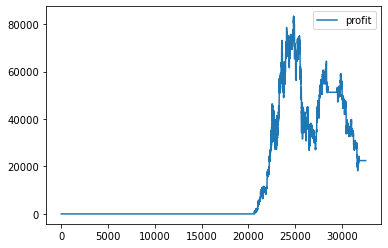

In [68]:
result_df[["trade_date", "profit"]].plot()

In [65]:
result_df.to_csv("results.xls", sep="\t", index=None)